In [1]:
import pandas as pd
from collections import Counter
from string import punctuation
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from src.data.cleaning import prepare

# Load Data

In [2]:
df = pd.read_csv('../data/processed/drugs.csv', usecols=['target', 'text'])

In [3]:
df.head(10)

,target,text
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t..."
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...
2,OPHTHALMIC,DOSAGE AND ADMINISTRATION The recommended dosa...
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...
4,TOPICAL,"Directions wet face, apply to hand, massage fa..."
5,ORAL,Dissolve pellets under the tongue 3-4 times da...
6,ORAL,2 DOSAGE AND ADMINISTRATION The recommended do...
7,ORAL,2 DOSAGE AND ADMINISTRATION Recommended starti...
8,ORAL,DOSAGE AND ADMINISTRATION Methocarbamol tablet...
9,TOPICAL,"Directions • for itching of skin irritation, i..."


# Split on Whitespace

The simplest tokenization just splits on whitespace. Let's try this and explore the results. 

In [4]:
pipeline = [str.lower, str.split]

In [5]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [6]:
df.head()

,target,text,tokens
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...","[dosage, adults-, take, 4, or, 6, pellets, by,..."
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...,"[directions, adults:, dissolve, 3, to, 5, unde..."
2,OPHTHALMIC,DOSAGE AND ADMINISTRATION The recommended dosa...,"[dosage, and, administration, the, recommended..."
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...,"[2, dosage, and, administration, use, the, low..."
4,TOPICAL,"Directions wet face, apply to hand, massage fa...","[directions, wet, face,, apply, to, hand,, mas..."


In [7]:
# create list of all tokens
all_tokens = []
df['tokens'].apply(lambda x: all_tokens.extend(x))
print(len(all_tokens))

24421689


In [8]:
token_counts = Counter(all_tokens)

In [9]:
types = token_counts.keys()

In [10]:
print("Splitting on whitespace yields {0} tokens and {1} types.".format(token_counts.total(), len(types)))

Splitting on whitespace yields 24421689 tokens and 64199 types.


In [11]:
token_counts.most_common(50)

[('the', 848539),
 ('of', 767461),
 ('to', 633474),
 ('and', 575946),
 ('in', 429288),
 ('for', 368782),
 ('a', 364693),
 ('be', 332645),
 ('mg', 325358),
 ('or', 316398),
 ('with', 314044),
 ('dose', 312722),
 ('is', 274128),
 ('patients', 241160),
 ('should', 200433),
 ('dosage', 196400),
 ('not', 180881),
 ('daily', 147990),
 ('2', 147436),
 ('may', 143369),
 ('as', 141416),
 ('tablets', 136213),
 ('use', 120618),
 ('at', 119581),
 ('recommended', 115267),
 ('(', 107298),
 ('by', 98786),
 ('on', 96178),
 ('than', 92008),
 ('every', 90687),
 ('treatment', 89119),
 ('if', 88270),
 ('once', 87857),
 ('1', 86486),
 ('years', 86239),
 ('hours', 84855),
 ('administration', 82274),
 ('12', 80998),
 ('10', 78751),
 ('doses', 76240),
 ('children', 75587),
 ('after', 75287),
 ('are', 74859),
 ('clinical', 74403),
 ('day', 72896),
 ('4', 70393),
 (')', 70256),
 ('•', 68949),
 ('[see', 67200),
 ('5', 63663)]

The top 30 typtes contain many stopwords. A few of them contain punctuation. 

Let's look for other types containing punctuation.

In [12]:
punct_set = set(punctuation)

In [13]:
def contains_punct(text):
    for char in text:
        if char in punct_set:
            return True
    return False

In [14]:
types_with_punct = {t: count for t, count in token_counts.items() if contains_punct(t)}

In [15]:
types_with_punct = sorted(types_with_punct.items(), key=lambda item: item[1], reverse=True)

In [16]:
types_with_punct[:50]

[('(', 107298),
 (')', 70256),
 ('[see', 67200),
 ('mg/day', 45567),
 ('.', 43985),
 ('2.1', 37047),
 ('daily.', 36155),
 ('2.2', 33025),
 ('mg/kg', 32145),
 (',', 31335),
 ('extended-release', 28900),
 ('(see', 27689),
 (').', 24251),
 ('2.5', 24191),
 ('2.3', 24170),
 ('day.', 21962),
 (']', 19886),
 ('].', 19498),
 ('dose.', 18605),
 ('2.4', 18528),
 ('days.', 17314),
 ('hours.', 15769),
 (')]', 15036),
 ('-', 14972),
 ('mg/kg/day', 13261),
 ('injection,', 13092),
 ('tablets,', 12753),
 ('(e.g.,', 12019),
 ('mg,', 11707),
 ('delayed-release', 11700),
 ('dose,', 11573),
 ('age:', 11570),
 ('daily,', 11496),
 ('patients,', 11068),
 ('mg.', 10714),
 ('however,', 10578),
 ('and/or', 10309),
 ('doses.', 10272),
 (')].', 10141),
 ('mg/m', 10133),
 ('day,', 9997),
 ('therapy.', 9587),
 ('mg/day.', 9445),
 ('hours,', 9309),
 ('weeks.', 9253),
 ('[', 9128),
 ('response.', 8949),
 ('recommended.', 8927),
 ('patients.', 8922),
 ('patient.', 8804)]

It seems fairly common for words to be combined with '/'. Let's take a look at these specifically. 

In [17]:
[(t, count) for t, count in dict(types_with_punct).items() if '/' in t][:50]

[('mg/day', 45567),
 ('mg/kg', 32145),
 ('mg/kg/day', 13261),
 ('and/or', 10309),
 ('mg/m', 10133),
 ('mg/day.', 9445),
 ('ml/min', 8166),
 ('mg/ml', 6093),
 ('mg/day,', 4371),
 ('ml/min/1.73', 3477),
 ('mg/kg/day,', 3105),
 ('mg/5', 3033),
 ('mcg/kg/day', 2646),
 ('mg/125', 2465),
 ('ml/min)', 2321),
 ('1/2', 2209),
 ('ml/min,', 2067),
 ('mcg/kg/min', 2004),
 ('mcg/ml', 1944),
 ('mg/kg/day.', 1941),
 ('lopinavir/ritonavir', 1880),
 ('mg/day)', 1837),
 ('(ml/min)', 1778),
 ('ml/min.', 1748),
 ('ml/minute/1.73', 1728),
 ('mg/day).', 1676),
 ('atazanavir/ritonavir', 1666),
 ('(mg/day)', 1634),
 ('/', 1577),
 ('/l', 1505),
 ('mg/ml)', 1498),
 ('mg/dl', 1447),
 ('pharyngitis/tonsillitis', 1301),
 ('mcg/kg', 1173),
 ('mg/25', 1154),
 ('ng/ml', 1059),
 ('ml/min/1.73m', 909),
 ('cells/mm', 891),
 ('mg/kg)', 887),
 ('ml/min),', 874),
 ('mg/kg,', 857),
 ('mcg/day', 849),
 ('ml/minute', 840),
 ('ml/h', 807),
 ('caregiver/family', 791),
 ('mg/kg.', 787),
 ('mg/ml.', 773),
 ('(mg/dl)', 763),
 ('(o

Most of these represent units of measurement (e.g. 'mg/day'). However, some of them represent combinations of distinct concepts (e.g. 'caregiver/family', 'pharyngitis/tonsillitis'). Splitting on whitespace would treat these as a single token, which would add unnecessary noise to the corpus. Let's try splitting on whitespace AND on '/'.  

# Split on Whitespace and '/'

In [18]:
def tokenize(text):
    pattern = re.compile(r'[\s/]')
    tokens = re.split(pattern, text)
    tokens = [t for t in tokens if t != '']
    return tokens

In [19]:
tokenize('mg/day foo bar')

['mg', 'day', 'foo', 'bar']

In [20]:
pipeline = [str.lower, tokenize]

In [21]:
df['tokens_slash'] = df['text'].apply(prepare, pipeline=pipeline)

In [22]:
df.head()

,target,text,tokens,tokens_slash
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...","[dosage, adults-, take, 4, or, 6, pellets, by,...","[dosage, adults-, take, 4, or, 6, pellets, by,..."
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...,"[directions, adults:, dissolve, 3, to, 5, unde...","[directions, adults:, dissolve, 3, to, 5, unde..."
2,OPHTHALMIC,DOSAGE AND ADMINISTRATION The recommended dosa...,"[dosage, and, administration, the, recommended...","[dosage, and, administration, the, recommended..."
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...,"[2, dosage, and, administration, use, the, low...","[2, dosage, and, administration, use, the, low..."
4,TOPICAL,"Directions wet face, apply to hand, massage fa...","[directions, wet, face,, apply, to, hand,, mas...","[directions, wet, face,, apply, to, hand,, mas..."


In [23]:
# create list of all tokens
all_tokens = []
df['tokens_slash'].apply(lambda x: all_tokens.extend(x))
print(len(all_tokens))

24726907


In [24]:
token_counts = Counter(all_tokens)

In [25]:
types = token_counts.keys()

In [26]:
print("Splitting on whitespace and '/' yields {0} tokens and {1} types.".format(token_counts.total(), len(types)))

Splitting on whitespace and '/' yields 24726907 tokens and 61744 types.


In [27]:
token_counts.most_common(50)

[('the', 848539),
 ('of', 767461),
 ('to', 633474),
 ('and', 586264),
 ('mg', 485203),
 ('in', 429291),
 ('for', 368796),
 ('a', 365208),
 ('be', 332645),
 ('or', 326760),
 ('with', 314045),
 ('dose', 313749),
 ('is', 274128),
 ('patients', 241359),
 ('should', 200433),
 ('dosage', 196425),
 ('not', 180883),
 ('2', 150658),
 ('daily', 148068),
 ('may', 143369),
 ('as', 141416),
 ('day', 138264),
 ('tablets', 136331),
 ('use', 120639),
 ('at', 119581),
 ('recommended', 115267),
 ('(', 107300),
 ('by', 98786),
 ('on', 96191),
 ('than', 92008),
 ('every', 90694),
 ('1', 89410),
 ('treatment', 89176),
 ('if', 88270),
 ('kg', 87891),
 ('once', 87860),
 ('ml', 87729),
 ('years', 86239),
 ('hours', 84858),
 ('administration', 82283),
 ('12', 81025),
 ('10', 79827),
 ('doses', 76247),
 ('after', 75972),
 ('children', 75613),
 ('are', 74859),
 ('clinical', 74403),
 ('4', 71042),
 (')', 70256),
 ('•', 68949)]

# Split on Whitespace and '-'

Some of the most common types also included '-'. Let's take a look at them. 

In [28]:
{t: count for t, count in token_counts.items() if '-' in t}

{'adults-': 112,
 'older-': 108,
 '(one-half': 184,
 'naproxen-containing': 202,
 'long-term': 5254,
 'anti-inflammatory': 815,
 'solid-oral': 128,
 'weight-based': 1215,
 'one-half': 2487,
 'non-interchangeability': 232,
 '3-4': 1242,
 '2-11:': 523,
 'fda-approved': 209,
 '(weight-adjusted': 2,
 '-': 14985,
 'non-cutaneous': 4,
 '0-1,': 26,
 'half-life': 2092,
 'radio-isotope': 25,
 'thyroid-pituitary': 50,
 '26-ml': 11,
 'back-and-forth': 58,
 '24-hour': 4564,
 'high-potency': 19,
 'hypothalamic-pituitary-adrenal': 379,
 '2-3': 1167,
 'angiotensin-converting': 1,
 'twice-daily.': 2,
 'film-coated': 196,
 'ora-plus': 491,
 'ora-sweet': 774,
 'press-in': 12,
 '(child-pugh': 3218,
 '5-10': 471,
 '1-5': 542,
 'well-controlled': 462,
 'end-stage': 918,
 'pre-': 131,
 'high-pressure': 50,
 '(mria-sp).': 5,
 'cyclosporine-therapeutic': 5,
 '50-200': 78,
 '50-150': 11,
 'obsessive-compulsive': 51,
 '6-12)': 35,
 '13-17).': 11,
 '25-200': 11,
 '(6-17': 11,
 'non-intravenous': 1290,
 '14-day':

In contrast to words combined with '/', these combined with '-' tend to represent a single concept. Splitting them into separate tokens would lose important information (e.g. 'non-psychotic'). 

# Final Tokenization

Based on the above analysis, we will split on whitespace and '/', and remove punctuation. 

In [29]:
punct_set = set(punctuation)
punct_set.remove('/') # don't remove '/' because we need it for tokenization 

In [30]:
def remove_punctuation(text):
    return "".join([char for char in text if char not in punct_set])  

In [31]:
pipeline = [str.lower, remove_punctuation, tokenize]

In [32]:
prepare('This is an example/test sentence!', pipeline=pipeline)

['this', 'is', 'an', 'example', 'test', 'sentence']

In [33]:
df['tokens_final'] = df['text'].apply(prepare, pipeline=pipeline)

In [34]:
df.head()

,target,text,tokens,tokens_slash,tokens_final
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...","[dosage, adults-, take, 4, or, 6, pellets, by,...","[dosage, adults-, take, 4, or, 6, pellets, by,...","[dosage, adults, take, 4, or, 6, pellets, by, ..."
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...,"[directions, adults:, dissolve, 3, to, 5, unde...","[directions, adults:, dissolve, 3, to, 5, unde...","[directions, adults, dissolve, 3, to, 5, under..."
2,OPHTHALMIC,DOSAGE AND ADMINISTRATION The recommended dosa...,"[dosage, and, administration, the, recommended...","[dosage, and, administration, the, recommended...","[dosage, and, administration, the, recommended..."
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...,"[2, dosage, and, administration, use, the, low...","[2, dosage, and, administration, use, the, low...","[2, dosage, and, administration, use, the, low..."
4,TOPICAL,"Directions wet face, apply to hand, massage fa...","[directions, wet, face,, apply, to, hand,, mas...","[directions, wet, face,, apply, to, hand,, mas...","[directions, wet, face, apply, to, hand, massa..."


In [35]:
# create list of all tokens
all_tokens = []
df['tokens_final'].apply(lambda x: all_tokens.extend(x))
print(len(all_tokens))

24308694


In [36]:
token_counts = Counter(all_tokens)

In [37]:
types = token_counts.keys()

In [38]:
print("Splitting on whitespace and '/' and removing punctuation yields {0} tokens and {1} types.".format(token_counts.total(), len(types)))

Splitting on whitespace and '/' and removing punctuation yields 24308694 tokens and 34091 types.


In [39]:
token_counts.most_common(50)

[('the', 848968),
 ('of', 768443),
 ('to', 635668),
 ('and', 587914),
 ('mg', 524520),
 ('in', 430771),
 ('for', 371437),
 ('a', 368313),
 ('dose', 355760),
 ('be', 332674),
 ('or', 330999),
 ('with', 315480),
 ('is', 275330),
 ('patients', 275135),
 ('dosage', 206939),
 ('daily', 205849),
 ('day', 203925),
 ('should', 201968),
 ('not', 182158),
 ('2', 171345),
 ('tablets', 162120),
 ('may', 143918),
 ('as', 142491),
 ('use', 132066),
 ('recommended', 127493),
 ('at', 120074),
 ('1', 116033),
 ('hours', 114260),
 ('see', 113201),
 ('ml', 109814),
 ('treatment', 104135),
 ('kg', 100617),
 ('by', 99299),
 ('years', 98130),
 ('on', 96339),
 ('administration', 95238),
 ('doses', 95039),
 ('every', 92562),
 ('than', 92010),
 ('if', 90153),
 ('once', 89047),
 ('10', 88918),
 ('12', 87395),
 ('children', 84198),
 ('5', 81370),
 ('4', 78639),
 ('therapy', 77163),
 ('after', 76492),
 ('are', 75090),
 ('clinical', 74409)]

## Stopwords EDA

In [40]:
#install the ntlk package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to C:\Users\Luke-
[nltk_data]     Workstation\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
stopWords = stopwords.words('english') # will start of with english stopwords
print(len(stopWords)) # check the number of stopwords

179


In [59]:
print(stopWords) # print out the stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [43]:
df.head(10) # check the df to get an idea of the words

,target,text,tokens,tokens_slash,tokens_final
0,ORAL,"DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...","[dosage, adults-, take, 4, or, 6, pellets, by,...","[dosage, adults-, take, 4, or, 6, pellets, by,...","[dosage, adults, take, 4, or, 6, pellets, by, ..."
1,ORAL,DIRECTIONS Adults: Dissolve 3 to 5 under the t...,"[directions, adults:, dissolve, 3, to, 5, unde...","[directions, adults:, dissolve, 3, to, 5, unde...","[directions, adults, dissolve, 3, to, 5, under..."
2,OPHTHALMIC,DOSAGE AND ADMINISTRATION The recommended dosa...,"[dosage, and, administration, the, recommended...","[dosage, and, administration, the, recommended...","[dosage, and, administration, the, recommended..."
3,ORAL,2 DOSAGE AND ADMINISTRATION Use the lowest eff...,"[2, dosage, and, administration, use, the, low...","[2, dosage, and, administration, use, the, low...","[2, dosage, and, administration, use, the, low..."
4,TOPICAL,"Directions wet face, apply to hand, massage fa...","[directions, wet, face,, apply, to, hand,, mas...","[directions, wet, face,, apply, to, hand,, mas...","[directions, wet, face, apply, to, hand, massa..."
5,ORAL,Dissolve pellets under the tongue 3-4 times da...,"[dissolve, pellets, under, the, tongue, 3-4, t...","[dissolve, pellets, under, the, tongue, 3-4, t...","[dissolve, pellets, under, the, tongue, 34, ti..."
6,ORAL,2 DOSAGE AND ADMINISTRATION The recommended do...,"[2, dosage, and, administration, the, recommen...","[2, dosage, and, administration, the, recommen...","[2, dosage, and, administration, the, recommen..."
7,ORAL,2 DOSAGE AND ADMINISTRATION Recommended starti...,"[2, dosage, and, administration, recommended, ...","[2, dosage, and, administration, recommended, ...","[2, dosage, and, administration, recommended, ..."
8,ORAL,DOSAGE AND ADMINISTRATION Methocarbamol tablet...,"[dosage, and, administration, methocarbamol, t...","[dosage, and, administration, methocarbamol, t...","[dosage, and, administration, methocarbamol, t..."
9,TOPICAL,"Directions • for itching of skin irritation, i...","[directions, •, for, itching, of, skin, irrita...","[directions, •, for, itching, of, skin, irrita...","[directions, •, for, itching, of, skin, irrita..."


In [61]:
#function for removing the stopwords from the token column
def remove_stopwords(text):
    return " ".join(word for word in str(text).split() if word not in stopWords)

In [60]:
# function  for cleaning the stopwords
text_st = ' when is a good time to go running only for about five hours and again look above'
remove_stopwords(text_st)

'good time go running five hours look'

In [62]:
#check the output from the text column
df['stop_removed'] = df['text'].apply(lambda text: remove_stopwords(text))
df['stop_removed'].head(10)

0    DOSAGE Adults- Take 4 6 Pellets mouth, three t...
1    DIRECTIONS Adults: Dissolve 3 5 tongue three t...
2    DOSAGE AND ADMINISTRATION The recommended dosa...
3    2 DOSAGE AND ADMINISTRATION Use lowest effecti...
4    Directions wet face, apply hand, massage face ...
5    Dissolve pellets tongue 3-4 times daily. Ages ...
6    2 DOSAGE AND ADMINISTRATION The recommended do...
7    2 DOSAGE AND ADMINISTRATION Recommended starti...
8    DOSAGE AND ADMINISTRATION Methocarbamol tablet...
9    Directions • itching skin irritation, inflamma...
Name: stop_removed, dtype: object

In [47]:
#check the function on the tokens
df['stop_removed_tokens'] = df['tokens_final'].apply(lambda text: remove_stopwords(text))
# df['stop_removed_tokens']= df['stop_removed_tokens'].astype(str)
df['stop_removed_tokens'].head(10)

0    ['dosage', 'adults', 'take', '4', 'or', '6', '...
1    ['directions', 'adults', 'dissolve', '3', 'to'...
2    ['dosage', 'and', 'administration', 'the', 're...
3    ['2', 'dosage', 'and', 'administration', 'use'...
4    ['directions', 'wet', 'face', 'apply', 'to', '...
5    ['dissolve', 'pellets', 'under', 'the', 'tongu...
6    ['2', 'dosage', 'and', 'administration', 'the'...
7    ['2', 'dosage', 'and', 'administration', 'reco...
8    ['dosage', 'and', 'administration', 'methocarb...
9    ['directions', '•', 'for', 'itching', 'of', 's...
Name: stop_removed_tokens, dtype: object

the function didnt remove the stopwords from the tokens , the next step create a function for the tokenized words

In [48]:
#function for removing the stopwords from the token column
def remove_stop_tokens(tokens):
    words = [ t for t in tokens if not t in stopWords]
    return " ".join(words)

In [49]:
#check the remove token function 
df['stop_removed_tokens'] = df['tokens_final'].apply(lambda text: remove_stop_tokens(text))
# df['stop_removed_tokens']= df['stop_removed_tokens'].astype(str)
df['stop_removed_tokens'].head(10)

0    dosage adults take 4 6 pellets mouth three tim...
1    directions adults dissolve 3 5 tongue three ti...
2    dosage administration recommended dosage regim...
3    2 dosage administration use lowest effective d...
4    directions wet face apply hand massage face ge...
5    dissolve pellets tongue 34 times daily ages 12...
6    2 dosage administration recommended dosage mek...
7    2 dosage administration recommended starting d...
8    dosage administration methocarbamol tablets us...
9    directions • itching skin irritation inflammat...
Name: stop_removed_tokens, dtype: object

In [50]:
print(df['stop_removed_tokens'].head(20))

0     dosage adults take 4 6 pellets mouth three tim...
1     directions adults dissolve 3 5 tongue three ti...
2     dosage administration recommended dosage regim...
3     2 dosage administration use lowest effective d...
4     directions wet face apply hand massage face ge...
5     dissolve pellets tongue 34 times daily ages 12...
6     2 dosage administration recommended dosage mek...
7     2 dosage administration recommended starting d...
8     dosage administration methocarbamol tablets us...
9     directions • itching skin irritation inflammat...
10    dosage administration dosage thyroid hormones ...
11    directions use care premature infants infants ...
12    directions adults apply 2 sprays onto tongue a...
13    directions take directed adults children 12 ye...
14    directions take 6 doses 24hour period measure ...
15    directions instill 1 2 drops affected eyes needed
16    dosage administration section directions ages ...
17    2 dosage administration apply thin film be

words such as directions,dosage appear frequently given that it a dataset involving drugs is to be expected, the next step is to plot the frequent words and add frequent ones to the stopwords


flatten_tokens[:10]: ['dosage', 'adults', 'take', '4', 'or', '6', 'pellets', 'by', 'mouth', 'three']


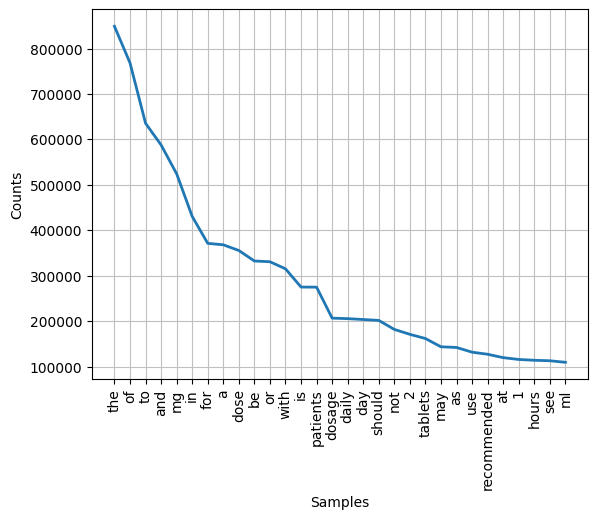

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [51]:
# plot the distribution of the words and compare the frequency after removing stop words
flatten_tokens = [y for x in df['tokens_final'] for y in x]  # flatten the list of token lists to a single list
print("flatten_tokens[:10]:", flatten_tokens[:10])

freq_tokens = nltk.FreqDist(flatten_tokens)
del freq_tokens['']
freq_sorted = sorted(freq_tokens.items(), key=lambda x: x[1], reverse=True)  # sorted list
# print(freq_sorted) # prints everything
    
freq_tokens.plot(30, cumulative=False)

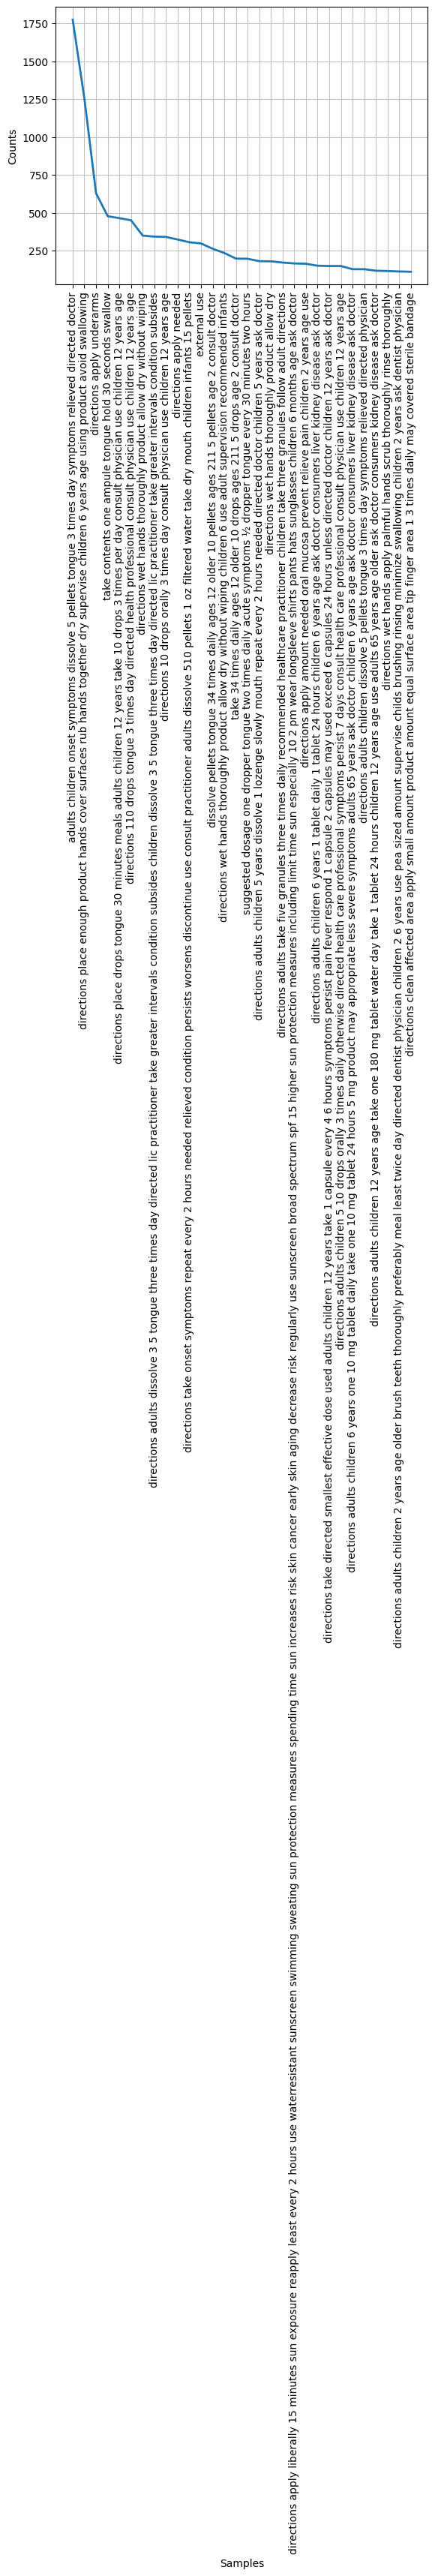

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [52]:
flatten_tokens2 = df['stop_removed_tokens'] .tolist()
freq_tokens2 = nltk.FreqDist(flatten_tokens2)
freq_sorted2 = sorted(freq_tokens2.items(), key=lambda x: x[1], reverse=True)  # sorted list
# print(freq_sorted2)
    
freq_tokens2.plot(30, cumulative=False)

In [53]:
token_counts.most_common(50)

[('the', 848968),
 ('of', 768443),
 ('to', 635668),
 ('and', 587914),
 ('mg', 524520),
 ('in', 430771),
 ('for', 371437),
 ('a', 368313),
 ('dose', 355760),
 ('be', 332674),
 ('or', 330999),
 ('with', 315480),
 ('is', 275330),
 ('patients', 275135),
 ('dosage', 206939),
 ('daily', 205849),
 ('day', 203925),
 ('should', 201968),
 ('not', 182158),
 ('2', 171345),
 ('tablets', 162120),
 ('may', 143918),
 ('as', 142491),
 ('use', 132066),
 ('recommended', 127493),
 ('at', 120074),
 ('1', 116033),
 ('hours', 114260),
 ('see', 113201),
 ('ml', 109814),
 ('treatment', 104135),
 ('kg', 100617),
 ('by', 99299),
 ('years', 98130),
 ('on', 96339),
 ('administration', 95238),
 ('doses', 95039),
 ('every', 92562),
 ('than', 92010),
 ('if', 90153),
 ('once', 89047),
 ('10', 88918),
 ('12', 87395),
 ('children', 84198),
 ('5', 81370),
 ('4', 78639),
 ('therapy', 77163),
 ('after', 76492),
 ('are', 75090),
 ('clinical', 74409)]

In [63]:
#add new words to the stopwords list
additional_stopwords = ["dosage","directions","dose", "day", "should", "not","recommended","with"]
stopWords.extend(additional_stopwords)
len(stopWords)# check to see if the words have been added

187

In [64]:
pipeline = [str.lower,remove_stopwords, remove_punctuation, tokenize]


In [65]:
df['stop_removed_tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df['stop_removed_tokens'].head(10)

0    [adults, take, 4, 6, pellets, mouth, three, ti...
1    [adults, dissolve, 3, 5, tongue, three, times,...
2    [administration, regimen, treatment, bacterial...
3    [2, administration, use, lowest, effective, sh...
4    [wet, face, apply, hand, massage, face, gently...
5    [dissolve, pellets, tongue, 34, times, daily, ...
6    [2, administration, mekinist, adult, patients,...
7    [2, administration, starting, 1, 2, mg, daily,...
8    [administration, methocarbamol, tablets, usp, ...
9    [•, itching, skin, irritation, inflammation, r...
Name: stop_removed_tokens, dtype: object